In [1]:
using Pkg 
pkg"activate ."
pkg"instantiate"

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


In [2]:
using OffsetArrays, Parameters, Plots, ForwardDiff, NLsolve, SpecialFunctions, BenchmarkTools, LinearAlgebra
using ForwardDiff: jacobian, derivative
using Perla1
gr(fmt = :png);

┌ Info: Recompiling stale cache file /Users/arnavsood/.julia/compiled/v1.1/OffsetArrays/UDEDl.ji for OffsetArrays [6fe1bfb0-de20-5000-8ca7-80f57d26f881]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/arnavsood/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/arnavsood/.julia/compiled/v1.1/ForwardDiff/k0ETY.ji for ForwardDiff [f6369f11-7733-5829-9624-2563aa707210]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/arnavsood/.julia/compiled/v1.1/NLsolve/KFCNP.ji for NLsolve [2774e3e8-f4cf-5e23-947b-6d7e65073b56]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/arnavsood/.julia/compiled/v1.1/Perla1/KuREK.ji for Perla1 [1ba507c4-04fb-439d-a50c-50cdde046eaf]
└ @ Base loading.jl:1184


# Model specification

In [3]:
params = params_demand_default_asymmetric_single_cohort()

(Ω = 1.0, σ = 0.15, mc = 1.0, κ = 3.5, Γ_bar = 0.865600495724366, N_k = 4, N = 8, N_ks = (4, 4), cohorts = (8,), q = 2.0:1.0:3.0)

In [4]:
N = sum(params.N_ks)
k_bar = length(params.N_ks)
b_bar = length(params.cohorts) # number of cohorts
f = fill(1/((N+1)^b_bar), (N+1)^b_bar); # awareness set distribution

# Demand function with 2-type firms

In [5]:
k = 1 # the quality type firm i belongs to
p = fill(1.0, k_bar); # k_bar-vector of prices

## Demand with 2-type under a single cohort

Consider firms belonging to one of the two types $L$ and $H$ with different qualities $q_L$ and $q_H$. An awareness set can be represented as $n = (N_L, N_H)$ where $N_L$ and $N_H$ denote the number of firms awared from $L$ and $H$ types respectively.

Given the awareness set distribution $f$, firm $i$ on $H$ type faces demand
$$
y_{i}(p_i, p_{-i}, f)
=  \bar{\Gamma}^{1-\kappa}\Omega \, q_H^{1/\sigma}p_i^{-1/\sigma - 1}\, \cdot \\
\sum_{n \in \mathcal{N} } f_n   \sum_{n_H =1}^n
\dfrac{n_H}{N_H}  \dfrac{\binom{N_H}{n_H} \binom{N_L}{n - n_H}}{\binom{N_H + N_L}{n}}
\left(
n_H \left( \dfrac{p_{H}}{q_{H}}   \right)^{-1/\sigma} +
(n - n_H) \left( \dfrac{p_{L}}{q_{L}}   \right)^{-1/\sigma} +
\dfrac{p_i^{-1/\sigma} - p^{-1/\sigma}_{H} }{ q_H^{-1/\sigma }}
\right)^{\sigma (\kappa - 1)-1}
$$

In [6]:
demand_single_cohort = demand_asymmetric_single_cohort
profit_single_cohort = get_profit(demand_single_cohort)
profit_derivative_single_cohort = get_profit_derivative(profit_single_cohort)

demand(p_i, k, p, f, params) = demand_single_cohort(p_i, k, p, f, params)
profit(p_i, k, p, f, params) = profit_single_cohort(p_i, k, 1, p, f, params)
profit_derivative(p_i, k, p, f, params) = profit_derivative_single_cohort(p_i, k, 1, p, f, params)

profit_derivative (generic function with 1 method)

## Extension: Demand with 2-type under multiple cohorts

Consider firms belonging to one of the two types $L$ and $H$ with different qualities $q_L$ and $q_H$. An awareness set can be represented as $n = (N_L, N_H)$ where $N_L$ and $N_H$ denote the number of firms awared from $L$ and $H$ types respectively.

Given the awareness set distribution $f$, firm $i$ of type $k$ in $b$ cohort faces demand

\begin{equation}\label{eq:full-total-demand-two-quality-multiple-cohort-alternative}
\begin{aligned}
& y_{ikb}(p_i, p_{-i}, f)
=  \bar{\Gamma}^{1-\kappa}\Omega \, q_k^{1/\sigma}p_i^{-1/\sigma - 1}\, \dfrac{1}{N_k} \cdot  \\
& \quad \sum_{n \in \mathcal{N} } f_n   \sum_{n_k \in \mathcal{V} (n) }
\Bigg\{
\left[ n_{kb} \prod_{b'=1}^{\bar b}
 \dfrac{\binom{N_k}{n_{kb'}} \binom{N_{-k}}{n_{b'} - n_{kb'}}}{\binom{N_k + N_L}{n_{b'}}}
\right] \cdot \\ & \quad
\Bigg[
\sum_{b' = 1}^{\bar b}
\left(
n_{kb'} \left( \dfrac{p_{kb}}{q_{k}}   \right)^{-1/\sigma} +
(n - n_{kb'}) \left( \dfrac{p_{(-k)b}}{q_{-k}}   \right)^{-1/\sigma} \right) +
\dfrac{p_i^{-1/\sigma} - p^{-1/\sigma}_{kb} }{ q_k^{-1/\sigma }}
\Bigg]^{\sigma (\kappa - 1)-1} \Bigg\}
\end{aligned}
\end{equation}

In [7]:
k = 1 # the quality type firm i belongs to
p = fill(1.0, k_bar, b_bar); # k_bar-vector of prices

In [8]:
demand(p_i, k, b, p, f, params) = demand_asymmetric(p_i, k, b, p, f, params)
profit(p_i, k, b, p, f, params) = (p_i - params.mc) * demand(p_i, k, b, p, f, params)
profit_derivative(p_i, k, b, p, f, params) = derivative(p_i -> profit(p_i, k, b, p, f, params), p_i)

profit_derivative (generic function with 2 methods)

## Plots

In [9]:
# two cohorts
params = params_demand_default_asymmetric()
N_ks = params.N_ks
N = sum(N_ks)
k_bar = length(N_ks)
b_bar = length(params.cohorts) # number of cohorts
p = fill(1.0, k_bar, b_bar)
half_size = Int64(round((N+1)^b_bar/2))
f = [fill(0.0, half_size+1); fill(1/half_size, half_size)]; # note that f is not uniform

### Demand

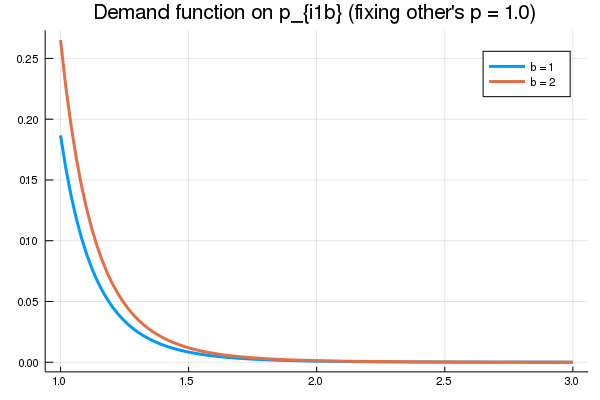

In [10]:
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> demand(p_i, 1, b, p, f, params))).(1:b_bar),
    label = string.("b = ",1:b_bar), lw = 3, title = "Demand function on p_{i1b} (fixing other's p = 1.0)")

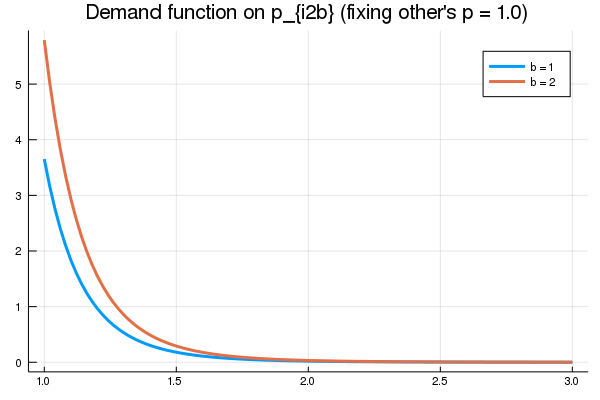

In [11]:
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> demand(p_i, 2, b, p, f, params))).(1:b_bar),
    label = string.("b = ",1:b_bar), lw = 3, title = "Demand function on p_{i2b} (fixing other's p = 1.0)")

### Profit

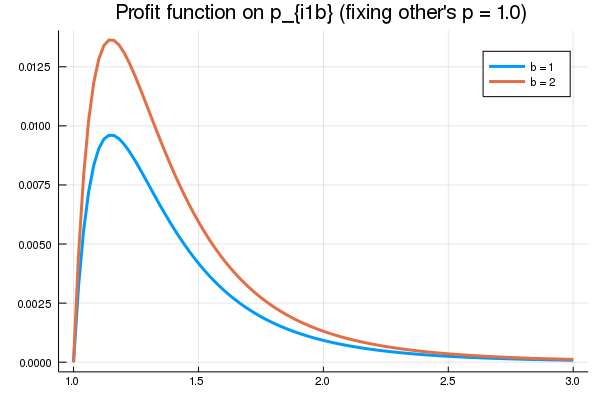

In [12]:
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> profit(p_i, 1, b, p, f, params))).(1:b_bar),
    label = string.("b = ",1:b_bar), lw = 3, title = "Profit function on p_{i1b} (fixing other's p = 1.0)")

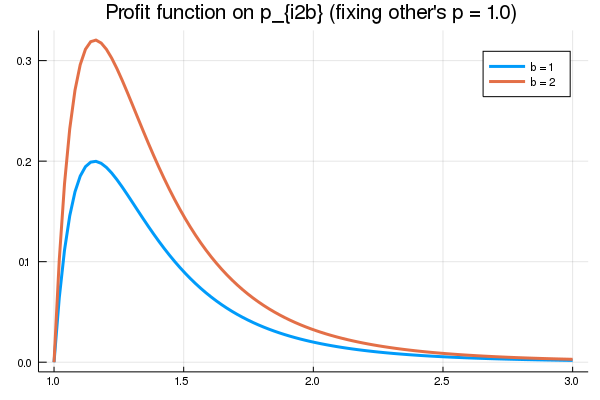

In [13]:
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> profit(p_i, 2, b, p, f, params))).(1:b_bar),
    label = string.("b = ",1:b_bar), lw = 3, title = "Profit function on p_{i2b} (fixing other's p = 1.0)")

## Nash equilibria

In [14]:
p = compute_price_equilibrium(f, params, profit).p # k_bar times b_bar matrix of equilibrium prices

2×2 Array{Float64,2}:
 1.15069  1.15065
 1.16617  1.16869

### Plots

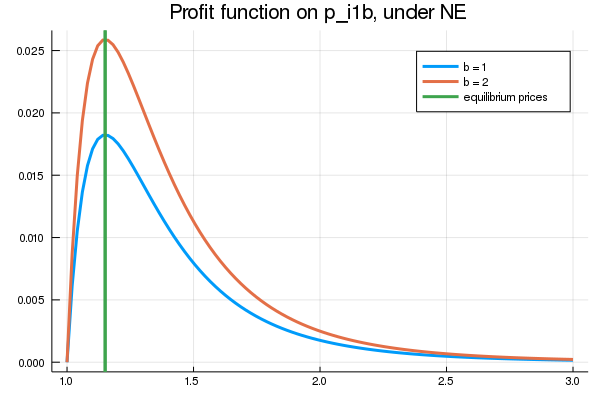

In [15]:
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> profit(p_i, 1, b, p, f, params))).(1:b_bar),
    label = string.("b = ",1:k_bar), lw = 3, title = "Profit function on p_i1b, under NE")
plot!(p[1,:], st = :vline, lw = 3, label = "equilibrium prices")

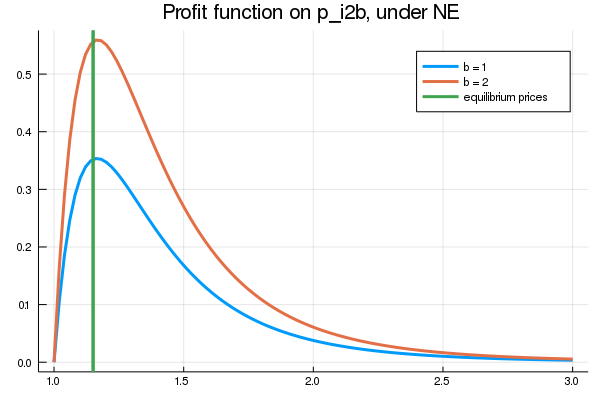

In [16]:
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> profit(p_i, 2, b, p, f, params))).(1:b_bar),
    label = string.("b = ",1:k_bar), lw = 3, title = "Profit function on p_i2b, under NE")
plot!(p[1,:], st = :vline, lw = 3, label = "equilibrium prices")

Note that equilbrium prices are identical across cohorts within the same quality type.

### Scenario 2: all firms are awared

In [17]:
f_all_awared = [fill(.0, length(f) - 1); 1]; # the last state is n = (N, N), where all firms are awared

In [18]:
p = compute_price_equilibrium(f_all_awared, params, profit).p # k_bar times b_bar matrix of equilibrium prices

2×2 Array{Float64,2}:
 1.15078  1.15078
 1.1618   1.1618 

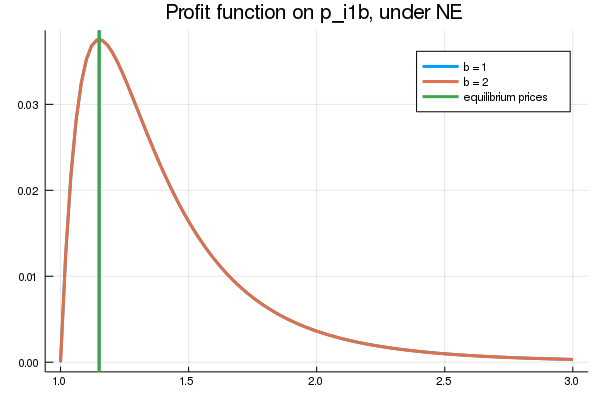

In [19]:
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> profit(p_i, 1, b, p, f_all_awared, params))).(1:b_bar),
    label = string.("b = ",1:k_bar), lw = 3, title = "Profit function on p_i1b, under NE")
plot!(p[1,:], st = :vline, lw = 3, label = "equilibrium prices")

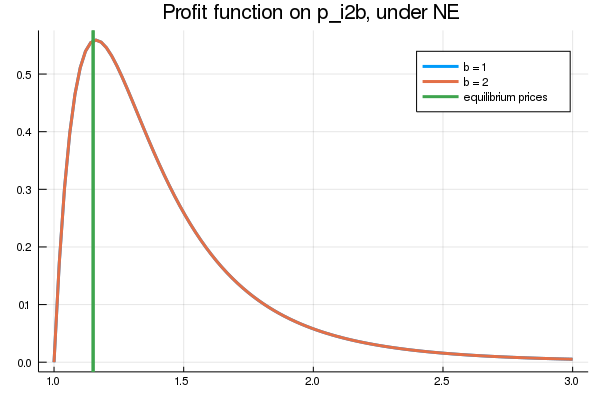

In [20]:
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> profit(p_i, 2, b, p, f_all_awared, params))).(1:b_bar),
    label = string.("b = ",1:k_bar), lw = 3, title = "Profit function on p_i2b, under NE")
plot!(p[1,:], st = :vline, lw = 3, label = "equilibrium prices")

Both equilibrium prices and profit functions are identical across cohorts within the same quality type.

### Scenario 3: the number of firms is doubled

In [21]:
N_ks = N_ks .* 2  # number of firms per quality group H and L
N = sum(N_ks)
cohorts = (N, N) # cohorts
half_size = Int64(round((N+1)^b_bar/2))
f_doubled = [fill(0.0, half_size+1); fill(1/half_size, half_size)] # note that f is not uniform
params_doubled = merge(params, (N_ks = N_ks, cohorts = cohorts))

(Ω = 1.0, σ = 0.15, mc = 1.0, κ = 3.5, Γ_bar = 0.865600495724366, N_k = 4, N = 8, N_ks = (8, 8), cohorts = (16, 16), q = 2.0:1.0:3.0)

In [22]:
p = compute_price_equilibrium(f_all_awared, params, profit).p # k_bar times b_bar matrix of equilibrium prices

2×2 Array{Float64,2}:
 1.15078  1.15078
 1.1618   1.1618 

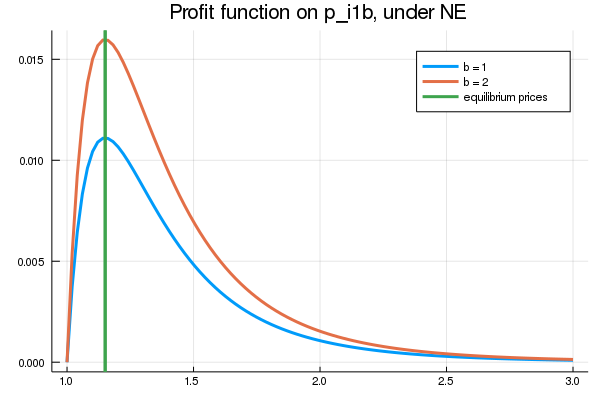

In [23]:
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> profit(p_i, 1, b, p, f_doubled, params_doubled))).(1:b_bar),
    label = string.("b = ",1:k_bar), lw = 3, title = "Profit function on p_i1b, under NE")
plot!(p[1,:], st = :vline, lw = 3, label = "equilibrium prices")

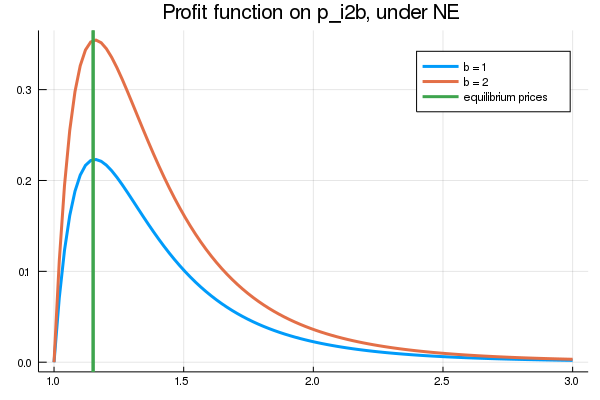

In [24]:
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> profit(p_i, 2, b, p, f_doubled, params_doubled))).(1:b_bar),
    label = string.("b = ",1:k_bar), lw = 3, title = "Profit function on p_i2b, under NE")
plot!(p[1,:], st = :vline, lw = 3, label = "equilibrium prices")